In [6]:
# standard libraries
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tqdm import tqdm
from scipy import signal
import scipy.stats as stats
import json
import random
from IPython.display import display
from tabulate import tabulate
from scipy.fft import fft, fftfreq

# third-party libraries
from pymatreader import read_mat
import mne
from nilearn import plotting

# custom libraries
import neuropsy as npsy

# ignore UserWarnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# check matplotlib backend
plt.rcParams._get_backend_or_none()

'module://matplotlib_inline.backend_inline'

### Load Data

In [ ]:
#******** Variable definitions ********
path_to_filepaths_file = './data/filepaths.json'
experiment_phase_of_interest = '2'                  # '1' is preview, '2' is learning, '3' is pre-sleep, and '4' is post-sleep


#******** Static definitions ********
fs = 512


#******** Initiate data object ********
data = Data(path_json=path_to_filepaths_file, experiment_phase_of_interest=experiment_phase_of_interest, fs=fs, verbose=False)
print("experiment metadata dataframe:")
display(data.df_exp.head())
print("channel metadata dataframe:")
display(data.df_chan.head())

experiment metadata dataframe:


,x_coordinate,y_coordinate,Picture Number,Reaction Time (RT),Subject ID,Mark for Picture Shown,Mark for Picture Placed,Timestamp (s) for Picture Shown,Timestamp (s) for Picture Placed,Reaction Time (computed),Trial Identifier
0,-59.0,-225.0,43,680.0,07,5119,6226,9.998047,12.160156,2.162109,1-43
1,302.0,203.0,20,780.0,07,7826,9002,15.285156,17.582031,2.296875,1-20
2,-125.0,211.0,4,820.0,07,10605,11824,20.712891,23.093750,2.380859,1-4
3,255.0,189.0,36,1380.0,07,13430,15125,26.230469,29.541016,3.310547,1-36
4,366.0,170.0,35,620.0,07,16724,17768,32.664062,34.703125,2.039062,1-35


channel metadata dataframe:


,elec_index,elec_label,DK_ROI,Prob,Lobe,x17Networks,Prob_1,x7Networks,Prob_2,BN_atlas,...,brodmann,Prob_4,perc_VTPM,Prob_5,Var16,data_chan,loc_1,loc_2,loc_3,name
0,1,101,ctx_lh_insula,0.41,Ins,Networks_8,0.60,Networks_7,0.63,INS_L_6_2,...,48,0.47,left_FEF,0.11,NaN,1,-33.712607,50.475984,16.131243,H 01
1,2,102,ctx_lh_insula,0.55,Ins,Networks_8,0.68,Networks_6,0.59,OrG_L_6_6,...,47,0.85,left_FEF,0.26,NaN,2,-36.396940,51.926302,17.808901,H 02
2,3,103,ctx_lh_insula,0.47,Ins,Networks_8,0.68,Networks_6,0.58,OrG_L_6_6,...,47,0.98,left_FEF,0.23,NaN,3,-39.019792,53.300565,19.452807,H 03
3,4,104,ctx_lh_lateralorbitofrontal,0.43,F,Networks_17,0.61,Networks_7,0.64,OrG_L_6_6,...,47,0.99,left_FEF,0.17,NaN,4,-41.813438,54.743383,21.239072,H 04
4,5,105,ctx_lh_parstriangularis,0.31,F,Networks_17,1.00,Networks_7,1.00,IFG_L_6_5,...,47,1.00,left_FEF,0.09,NaN,5,-44.582630,56.166276,23.033039,H 05


### Bar Chart of Trials

In [ ]:
filenames = os.listdir('data/')
r = re.compile("sub[0-9]{2}.mat")
subjects_filenames = list(filter(r.match, filenames))

fs = 512


for i, filename in enumerate(tqdm(subjects_filenames)):
    print(f'file {filename} is being loaded...')
    
    # load data
    data = Data(
        path='data/' + filename,
        experiment_phase_of_interest=2,
        fs=fs,
        verbose=False)
    
    # create new dataframe only in first loop
    if i == 0:
        # empty dataframe to store all subjects' experiment data
        print(f'creating new dataframe with {data.df_exp.shape[0]} rows...')
        df = data.df_exp.copy()
    # otherwise append data to dataframe
    else:
        ext_rows = []
        for new_row in data.df_exp.values.tolist():
            ext_rows.append(new_row)
            
        # create extension
        df_extended = pd.DataFrame(ext_rows, columns=df.columns)
        # concatenate to original
        print(f'appending {data.df_exp.shape[0]} rows to dataframe...')
        df = pd.concat([df, df_extended], ignore_index=True)
        
    
    # free memory
    del data
    
print(f'total rows in concatenated dataframe: {df.shape[0]}')
df.head()

  0%|          | 0/11 [00:00<?, ?it/s]

file sub03.mat is being loaded...


  9%|▉         | 1/11 [00:15<02:33, 15.31s/it]

creating new dataframe with 202 rows...
file sub04.mat is being loaded...


 18%|█▊        | 2/11 [00:43<03:25, 22.82s/it]

appending 228 rows to dataframe...
file sub05.mat is being loaded...


 27%|██▋       | 3/11 [00:59<02:37, 19.74s/it]

appending 130 rows to dataframe...
file sub07.mat is being loaded...


 36%|███▋      | 4/11 [01:26<02:37, 22.46s/it]

appending 425 rows to dataframe...
file sub09.mat is being loaded...


 45%|████▌     | 5/11 [01:52<02:24, 24.03s/it]

appending 306 rows to dataframe...
file sub10.mat is being loaded...


 55%|█████▍    | 6/11 [02:08<01:45, 21.13s/it]

appending 196 rows to dataframe...
file sub11.mat is being loaded...


 64%|██████▎   | 7/11 [02:29<01:24, 21.23s/it]

appending 279 rows to dataframe...
file sub12.mat is being loaded...


 73%|███████▎  | 8/11 [02:49<01:02, 20.80s/it]

appending 307 rows to dataframe...
file sub14.mat is being loaded...


 82%|████████▏ | 9/11 [03:06<00:38, 19.45s/it]

appending 221 rows to dataframe...
file sub15.mat is being loaded...


 91%|█████████ | 10/11 [03:25<00:19, 19.29s/it]

appending 348 rows to dataframe...
file sub19.mat is being loaded...


100%|██████████| 11/11 [03:44<00:00, 20.40s/it]

appending 304 rows to dataframe...
total rows in concatenated dataframe: 2946


,x_coordinate,y_coordinate,Picture Number,Reaction Time (RT),Subject ID,Mark for Picture Shown,Mark for Picture Placed,Timestamp (s) for Picture Shown,Timestamp (s) for Picture Placed,Reaction Time (computed),Trial Identifier
0,240.0,-252.0,47,5280.0,03,5119.0,10133.0,9.998047,19.791016,9.792969,47-1
1,247.0,-254.0,33,3060.0,03,11738.0,14864.0,22.925781,29.031250,6.105469,33-1
2,-248.0,200.0,36,1880.0,03,16466.0,18582.0,32.160156,36.292969,4.132812,36-1
3,-76.0,64.0,44,6400.0,03,20187.0,26168.0,39.427734,51.109375,11.681641,44-1
4,-252.0,-194.0,46,1780.0,03,27774.0,29805.0,54.246094,58.212891,3.966797,46-1


In [ ]:
df.to_csv('data/df_exp_all.csv', index=False)

In [ ]:
trials = pd.DataFrame(columns=['Subject ID', 'Picture Number', 'Counts'])

for sub in df['Subject ID'].unique():
    for pic in tqdm(np.sort(df['Picture Number'].unique())):
        count = df[df['Subject ID'] == sub].loc[df['Picture Number'] == pic, 'Picture Number'].count()
        # concatenate
        trials = pd.concat([trials, pd.DataFrame([[sub, pic, count]], columns=trials.columns)])

100%|██████████| 50/50 [00:00<00:00, 1273.14it/s]


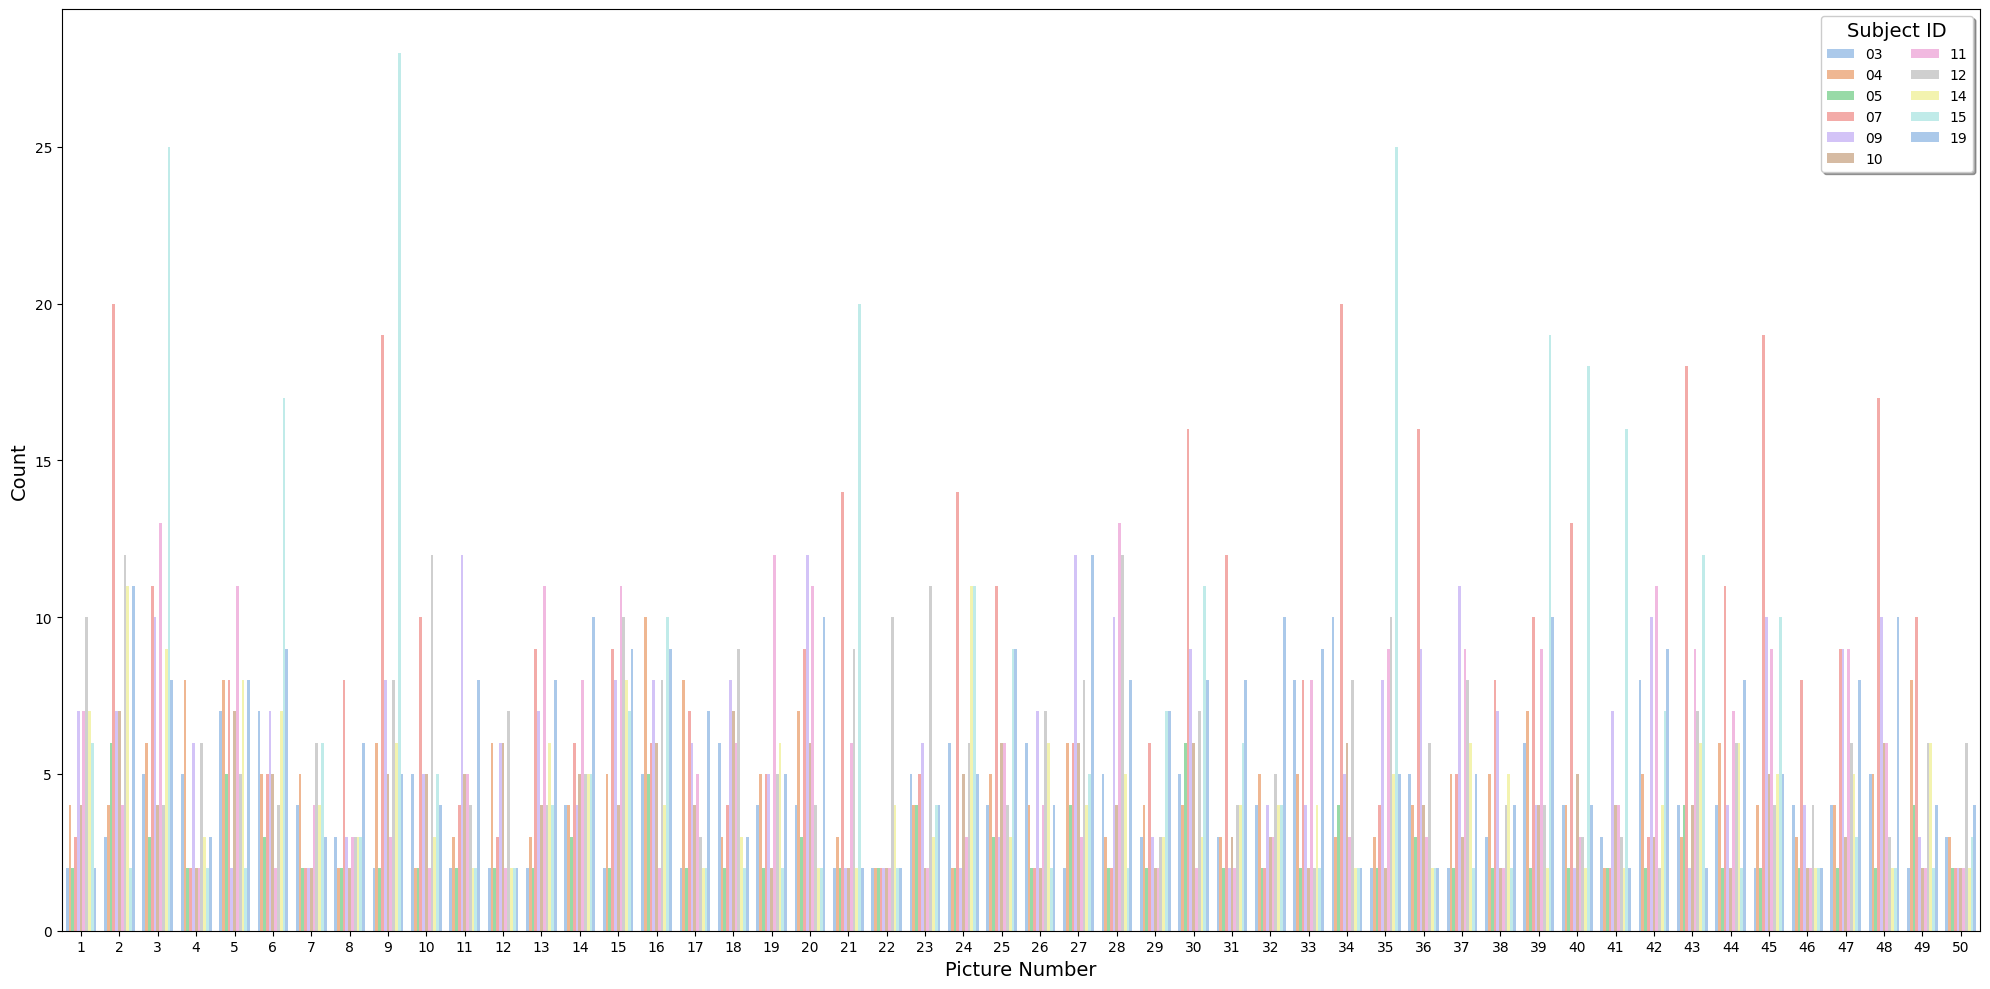

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(trials, x='Picture Number', y='Counts', hue='Subject ID', errorbar=None, palette='pastel')
plt.legend(loc='upper right', fancybox=True, shadow=True, ncol=2, title='Subject ID', title_fontsize=14)
plt.xlabel('Picture Number', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()

In [ ]:
subs = ['03', '04', '05', '07', '09', '10', '11', '12', '14', '15', '19']

N_total = 0
for s in subs:
    N_trials = df[df['Subject ID'] == s].shape[0]
    N_pics = df[df['Subject ID'] == s]['Picture Number'].unique().shape[0]    
    
    print(f'subject {s}:')
    print(f"\ttrials in total: {N_trials}")
    print(f"\tavg. trials used per picture: {N_trials / N_pics}")
    
    N_total += N_trials
print(f'total number of trials: {N_total}')

subject 03:
	trials in total: 202
	avg. trials used per picture: 4.04
subject 04:
	trials in total: 228
	avg. trials used per picture: 4.56
subject 05:
	trials in total: 130
	avg. trials used per picture: 2.6
subject 07:
	trials in total: 425
	avg. trials used per picture: 8.5
subject 09:
	trials in total: 306
	avg. trials used per picture: 6.12
subject 10:
	trials in total: 196
	avg. trials used per picture: 3.92
subject 11:
	trials in total: 279
	avg. trials used per picture: 5.58
subject 12:
	trials in total: 307
	avg. trials used per picture: 6.14
subject 14:
	trials in total: 221
	avg. trials used per picture: 4.42
subject 15:
	trials in total: 348
	avg. trials used per picture: 6.96
subject 19:
	trials in total: 304
	avg. trials used per picture: 6.08
total number of trials: 2946


### Difference in Reaction Time across Subjects 

In [ ]:
df = pd.read_csv('data/df_exp_all.csv')
display(df.head())

,x_coordinate,y_coordinate,Picture Number,Reaction Time (RT),Subject ID,Mark for Picture Shown,Mark for Picture Placed,Timestamp (s) for Picture Shown,Timestamp (s) for Picture Placed,Reaction Time (computed),Trial Identifier
0,240.0,-252.0,47,5280.0,3,5119.0,10133.0,9.998047,19.791016,9.792969,47-1
1,247.0,-254.0,33,3060.0,3,11738.0,14864.0,22.925781,29.031250,6.105469,33-1
2,-248.0,200.0,36,1880.0,3,16466.0,18582.0,32.160156,36.292969,4.132812,36-1
3,-76.0,64.0,44,6400.0,3,20187.0,26168.0,39.427734,51.109375,11.681641,44-1
4,-252.0,-194.0,46,1780.0,3,27774.0,29805.0,54.246094,58.212891,3.966797,46-1


In [ ]:
def determine_outlier_thresholds_std(dataframe, col_name):
    upper_boundary = dataframe[col_name].mean() + 3 * dataframe[col_name].std()
    lower_boundary = dataframe[col_name].mean() - 3 * dataframe[col_name].std()
    return lower_boundary, upper_boundary

def check_outliers_std(dataframe, col_name):
    lower_boundary, upper_boundary = determine_outlier_thresholds_std(dataframe, col_name)
    if dataframe[(dataframe[col_name] > upper_boundary) | (dataframe[col_name] < lower_boundary)].any(axis=None):
        return True
    else: 
        return False
    
def get_outlier_indices(dataframe, cols):
    data = []
    for col_name in cols:
        if col_name != 'Outcome':
            outliers_ = check_outliers_std(dataframe, col_name)
            count = None
            lower_limit, upper_limit = determine_outlier_thresholds_std(dataframe, col_name)
            if outliers_:
                count = dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)][col_name].count()
                indices = dataframe[(dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)].index.to_numpy()
            outliers_status = check_outliers_std(dataframe, col_name)
            data.append([outliers_, outliers_status, count, col_name, lower_limit, upper_limit])
    table = tabulate(data, headers=['Outlier (Previously)','Outliers','Count', 'Column','Lower Limit', 'Upper Limit'], tablefmt='rst', numalign='right')
    print("Removing Outliers using 3 Standard Deviation")
    print(table)
    return indices

# compute outliers within each subject
idx = []
for i, sub in enumerate(df['Subject ID'].unique()):
    print(f'subject {sub}:')
    idx.append(get_outlier_indices(
        dataframe=df[df['Subject ID'] == sub], 
        cols=['Reaction Time (computed)']
    ))
    print(f'\t{len(idx[i])} outliers found in subject {sub}\n')
    

# flatten array
idx = np.concatenate(idx)
print(f'total number of outliers: {len(idx)}')

# add column 'Outlier' to indicate if trial is an outlier
df['Outlier'] = df.index.isin(idx)
display(df.head())

subject 3:
Removing Outliers using 3 Standard Deviation
======================  ==========  =======  ========================  =============  =============
Outlier (Previously)    Outliers      Count  Column                      Lower Limit    Upper Limit
======================  ==========  =======  ========================  =============  =============
True                    True              5  Reaction Time (computed)       -3.08872        10.4383
======================  ==========  =======  ========================  =============  =============
	5 outliers found in subject 3

subject 4:
Removing Outliers using 3 Standard Deviation
======================  ==========  =======  ========================  =============  =============
Outlier (Previously)    Outliers      Count  Column                      Lower Limit    Upper Limit
======================  ==========  =======  ========================  =============  =============
True                    True              6  Reaction Ti

,x_coordinate,y_coordinate,Picture Number,Reaction Time (RT),Subject ID,Mark for Picture Shown,Mark for Picture Placed,Timestamp (s) for Picture Shown,Timestamp (s) for Picture Placed,Reaction Time (computed),Trial Identifier,Outlier
0,240.0,-252.0,47,5280.0,3,5119.0,10133.0,9.998047,19.791016,9.792969,47-1,False
1,247.0,-254.0,33,3060.0,3,11738.0,14864.0,22.925781,29.031250,6.105469,33-1,False
2,-248.0,200.0,36,1880.0,3,16466.0,18582.0,32.160156,36.292969,4.132812,36-1,False
3,-76.0,64.0,44,6400.0,3,20187.0,26168.0,39.427734,51.109375,11.681641,44-1,True
4,-252.0,-194.0,46,1780.0,3,27774.0,29805.0,54.246094,58.212891,3.966797,46-1,False


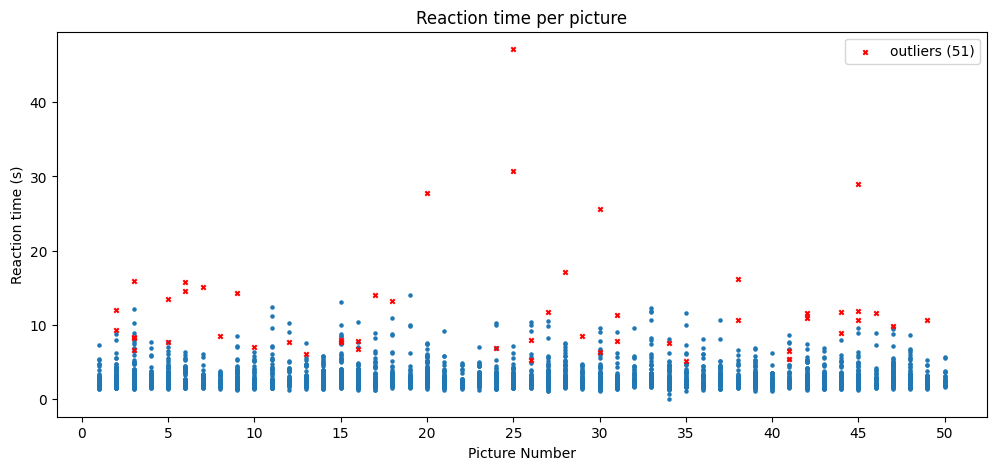

In [ ]:
_df1 = df.drop(idx)
_df2 = df.iloc[idx, :]

# plot computed reaction times
plt.figure(figsize=(12,5))
plt.scatter(_df1['Picture Number'], _df1['Reaction Time (computed)'], marker='.', s=20)
plt.scatter(_df2['Picture Number'], _df2['Reaction Time (computed)'], marker='x', s=10, color='red', label=f'outliers ({str(len(_df2))})')
plt.title('Reaction time per picture')
plt.xlabel('Picture Number')
plt.ylabel('Reaction time (s)')
plt.legend(loc='best')
plt.xticks(np.arange(0, 51, 5))
plt.show()

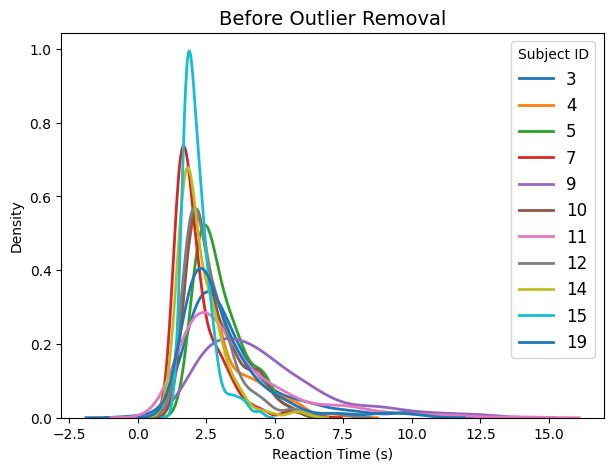

In [ ]:
df_tmp = df.drop(idx, inplace=False)
# df_tmp = df.copy()

subjects = df_tmp['Subject ID'].unique()

plt.figure(figsize=(7,5))
# Iterate through the subjects
for subject in subjects:
    # Subset of subject data
    subset = df_tmp[df_tmp['Subject ID'] == subject]
    
    # Draw the density plot
    sns.distplot(subset['Reaction Time (computed)'], hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = subject)
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Subject ID')
plt.title('Before Outlier Removal', fontsize=14)
plt.xlabel('Reaction Time (s)')
plt.ylabel('Density')
plt.show()

### T-tests on Reaction Time across Subjects

In [ ]:
df_tmp = df.drop(idx, inplace=False)
# df_tmp = df.copy()

subjects = df_tmp['Subject ID'].unique()

# Iterate through subejcts
for subject in subjects:
    
    i = 0
    for subject_ in [s for s in subjects if s != subject]:
        # Subset of subject data
        subset_x1 = df_tmp[df_tmp['Subject ID'] == subject]
        subset_x2 = df_tmp[df_tmp['Subject ID'] == subject_]
    
        # calculate two-sample t-test
        result = stats.ttest_ind(subset_x1['Reaction Time (computed)'], subset_x2['Reaction Time (computed)'], random_state=23)
        
        # print results
        print(f"Subjects {subject} and {subject_}:")
        print(f"\tmean ({subject}) = {subset_x1['Reaction Time (computed)'].mean()}")
        print(f"\tmean ({subject_}) = {subset_x2['Reaction Time (computed)'].mean()}")
        print(f"\tp-value = {round(result.pvalue, 4)}")
        print(f"\t{'significant difference' if result.pvalue < 0.05 else 'no significant difference'}")
        print()
    print("\n\n")
    
        # if result.pvalue < 0.05 or result.pvalue > 0.95: print(f"{subject} vs {subject_}: {round(result.pvalue, 4)}")
        
        # if result.pvalue < 0.05 or result.pvalue > 0.95: i += 1
    # print(f"{subject}: {i}")

Subjects 3 and 4:
	mean (3) = 3.2848103841145835
	mean (4) = 2.871970486111111
	p-value = 0.0023
	significant difference

Subjects 3 and 5:
	mean (3) = 3.2848103841145835
	mean (5) = 3.0566556490384613
	p-value = 0.1208
	no significant difference

Subjects 3 and 7:
	mean (3) = 3.2848103841145835
	mean (7) = 2.178336048578199
	p-value = 0.0
	significant difference

Subjects 3 and 9:
	mean (3) = 3.2848103841145835
	mean (9) = 4.30539035467128
	p-value = 0.0
	significant difference

Subjects 3 and 10:
	mean (3) = 3.2848103841145835
	mean (10) = 2.930972975127551
	p-value = 0.0112
	significant difference

Subjects 3 and 11:
	mean (3) = 3.2848103841145835
	mean (11) = 3.42710735701107
	p-value = 0.3648
	no significant difference

Subjects 3 and 12:
	mean (3) = 3.2848103841145835
	mean (12) = 2.679242728960396
	p-value = 0.0
	significant difference

Subjects 3 and 14:
	mean (3) = 3.2848103841145835
	mean (14) = 2.3705051369863015
	p-value = 0.0
	significant difference

Subjects 3 and 15:
	me

### Order of Appearance

In [ ]:
foo = data.df_exp[data.df_exp['Subject ID'] == '07'].loc[data.df_exp['Picture Number'] == 1].index.to_numpy() + 1
foo = np.insert(foo, 0, 0)
print(foo)
dis = [foo[i] - foo[i-1] for i in range(1, len(foo))]
print(dis)

[  0  41  88 137]
[41, 47, 49]


In [ ]:
filenames = os.listdir('data/')
r = re.compile("sub[0-9]{2}.mat")
subjects_filenames = list(filter(r.match, filenames))

fs = 512

len_between_trials = {}
for i, filename in enumerate(tqdm(subjects_filenames)):
    print(f'file {filename} is being loaded...')
    
    # load data
    data = Data(
        path='data/' + filename,
        experiment_phase_of_interest=2,
        fs=fs,
        verbose=False)
    
    len_between_trials[f'{data.subject_id}'] = {}
    # iterate over picture items
    for pic_num in sorted(data.df_exp['Picture Number'].unique()):
        trial_appearances = data.df_exp.loc[data.df_exp['Picture Number'] == pic_num].index.to_numpy() + 1
        trial_appearances = np.insert(trial_appearances, 0, 0)
        len_between_trials[f'{data.subject_id}'][f'pic_{str(pic_num)}'] = [trial_appearances[i+1] - trial_appearances[i] for i in range(len(trial_appearances)-1)]

  0%|          | 0/11 [00:00<?, ?it/s]

file sub03.mat is being loaded...


  9%|▉         | 1/11 [00:12<02:08, 12.85s/it]

file sub04.mat is being loaded...


 18%|█▊        | 2/11 [00:40<03:13, 21.55s/it]

file sub05.mat is being loaded...


 27%|██▋       | 3/11 [00:53<02:20, 17.57s/it]

file sub07.mat is being loaded...


 36%|███▋      | 4/11 [01:18<02:23, 20.54s/it]

file sub09.mat is being loaded...


 45%|████▌     | 5/11 [01:44<02:14, 22.36s/it]

file sub10.mat is being loaded...


 55%|█████▍    | 6/11 [02:00<01:42, 20.53s/it]

file sub11.mat is being loaded...


 64%|██████▎   | 7/11 [02:23<01:24, 21.02s/it]

file sub12.mat is being loaded...


 73%|███████▎  | 8/11 [02:47<01:06, 22.00s/it]

file sub14.mat is being loaded...


 82%|████████▏ | 9/11 [03:03<00:40, 20.24s/it]

file sub15.mat is being loaded...


 91%|█████████ | 10/11 [03:24<00:20, 20.35s/it]

file sub19.mat is being loaded...


100%|██████████| 11/11 [03:48<00:00, 20.80s/it]


In [ ]:
len_between_trials['19']

{'pic_1': [18, 56],
 'pic_2': [40, 43, 58, 2, 60, 25, 16, 28, 20, 7, 4],
 'pic_3': [17, 62, 27, 61, 14, 51, 10, 18],
 'pic_4': [12, 47, 66],
 'pic_5': [43, 55, 19, 62, 4, 42, 30, 26],
 'pic_6': [33, 31, 59, 42, 39, 22, 33, 15, 9],
 'pic_7': [21, 41, 53],
 'pic_8': [9, 45, 60, 57, 19, 25],
 'pic_9': [50, 26, 36, 40, 42],
 'pic_10': [35, 52, 35, 25],
 'pic_11': [26, 52, 30, 37, 57, 32, 20, 10],
 'pic_12': [31, 68],
 'pic_13': [48, 4, 58, 34, 54, 16, 31, 17],
 'pic_14': [5, 64, 34, 48, 36, 34, 20, 28, 21, 11],
 'pic_15': [32, 34, 39, 70, 30, 15, 28, 20, 16],
 'pic_16': [24, 73, 34, 30, 40, 11, 26, 39, 12],
 'pic_17': [14, 42, 51, 57, 44, 3, 42],
 'pic_18': [38, 47, 50],
 'pic_19': [2, 68, 48, 56, 36],
 'pic_20': [36, 52, 25, 57, 12, 35, 30, 14, 26, 8],
 'pic_21': [13, 68],
 'pic_22': [23, 49],
 'pic_23': [34, 50, 49, 15],
 'pic_24': [15, 36, 83, 44, 2],
 'pic_25': [45, 8, 86, 29, 23, 25, 27, 24, 15],
 'pic_26': [1, 93, 26, 43],
 'pic_27': [30, 38, 72, 17, 32, 42, 6, 29, 22, 10, 4, 2],
 'p

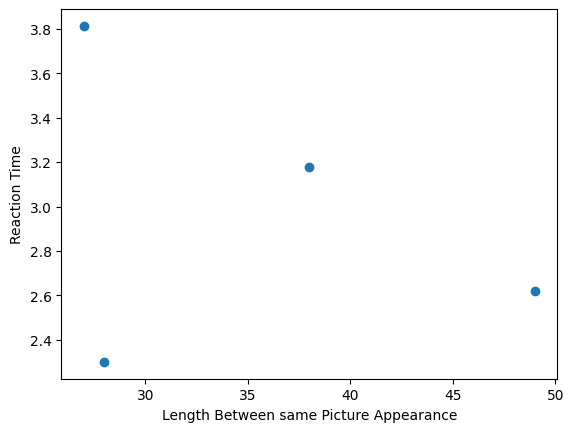

In [ ]:
pic = 50

x = len_between_trials['19'][f'pic_{str(pic)}']
y = data.df_exp.loc[data.df_exp['Picture Number'] == pic]['Reaction Time (computed)'].to_numpy()


plt.plot(x, y, 'o')
plt.xlabel('Length Between same Picture Appearance')
plt.ylabel('Reaction Time')
plt.show()

# Countplot After Categorise Trials

In [ ]:
import neuropsy as nps
import pandas as pd

path            = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
subject_ids     = nps.utils.get_subject_ids_from_path(path)


dict_subject_labels = {}
for i, sub_id in enumerate(subject_ids):
    dict_subject_labels[sub_id] = {}
    
    # load subject data
    data = nps.DataHandler(path=path, subject_id=sub_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed', load_chan=False, load_ieeg=False, load_targets=False)
    
    # get labels
    for label in data.df_exp['Trial Category'].unique():
        
        # first subject
        if i == 0:
            df = data.df_exp
        else:
            df = pd.concat([df, data.df_exp])
            
        dict_subject_labels[sub_id][label] = len(data.df_exp.loc[data.df_exp['Trial Category'] == label])
        print(f"Subject {sub_id} label {repr(label)}: {len(data.df_exp.loc[data.df_exp['Trial Category'] == label])}")
        
    

Subject 03 label 'uncertain': 75
Subject 03 label 'unknown': 27
Subject 03 label 'certain': 100
Subject 04 label 'uncertain': 94
Subject 04 label 'unknown': 27
Subject 04 label 'certain': 107
Subject 05 label 'unknown': 11
Subject 05 label 'certain': 98
Subject 05 label 'uncertain': 21
Subject 07 label 'uncertain': 238
Subject 07 label 'certain': 122
Subject 07 label 'unknown': 65
Subject 09 label 'uncertain': 138
Subject 09 label 'certain': 113
Subject 09 label 'unknown': 55
Subject 10 label 'unknown': 18
Subject 10 label 'certain': 105
Subject 10 label 'uncertain': 73
Subject 11 label 'uncertain': 124
Subject 11 label 'unknown': 39
Subject 11 label 'certain': 116
Subject 12 label 'uncertain': 147
Subject 12 label 'certain': 117
Subject 12 label 'unknown': 43
Subject 14 label 'uncertain': 80
Subject 14 label 'unknown': 35
Subject 14 label 'certain': 106
Subject 15 label 'uncertain': 142
Subject 15 label 'certain': 109
Subject 15 label 'unknown': 47
Subject 19 label 'unknown': 54
Subje

- box plot: NaNs removed within subjects and remaining trials (x=sub_id, y1=count)
- box plot: outliers removed within subjects and remaining trials (x=sub_id, y2=count)
- combine the two above in the same box plot with error bars

In [ ]:
# import libraries
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# load dataset
tips = sns.load_dataset("tips")

# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# set the figure size
plt.figure(figsize=(14, 14))

# top bar -> sum all values(smoker=No and smoker=Yes) to find y position of the bars
total = tips.groupby('day')['total_bill'].sum().reset_index()

# bar chart 1 -> top bars (group of 'smoker=No')
bar1 = sns.barplot(x="day",  y="total_bill", data=total, color='darkblue')

# bottom bar ->  take only smoker=Yes values from the data
smoker = tips[tips.smoker=='Yes']

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="day", y="total_bill", data=smoker, estimator=sum, ci=None,  color='lightblue')

# add legend
top_bar = mpatches.Patch(color='darkblue', label='smoker = No')
bottom_bar = mpatches.Patch(color='lightblue', label='smoker = Yes')
plt.legend(handles=[top_bar, bottom_bar])

# show the graph
plt.show()

In [ ]:
dict_subject_labels

{'03': {'uncertain': 75, 'unknown': 27, 'certain': 100},
 '04': {'uncertain': 94, 'unknown': 27, 'certain': 107},
 '05': {'unknown': 11, 'certain': 98, 'uncertain': 21},
 '07': {'uncertain': 238, 'certain': 122, 'unknown': 65},
 '09': {'uncertain': 138, 'certain': 113, 'unknown': 55},
 '10': {'unknown': 18, 'certain': 105, 'uncertain': 73},
 '11': {'uncertain': 124, 'unknown': 39, 'certain': 116},
 '12': {'uncertain': 147, 'certain': 117, 'unknown': 43},
 '14': {'uncertain': 80, 'unknown': 35, 'certain': 106},
 '15': {'uncertain': 142, 'certain': 109, 'unknown': 47},
 '19': {'unknown': 54, 'uncertain': 136, 'certain': 114}}

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
# First plot the 'Male' bars for every day.
ax.bar(agg_tips.index, agg_tips['Male'], label='Male')
# Then plot the 'Female' bars on top, starting at the top of the 'Male'
# bars.
ax.bar(agg_tips.index, agg_tips['Female'], bottom=agg_tips['Male'],
       label='Female')
ax.set_title('Tips by Day and Gender')
ax.legend()

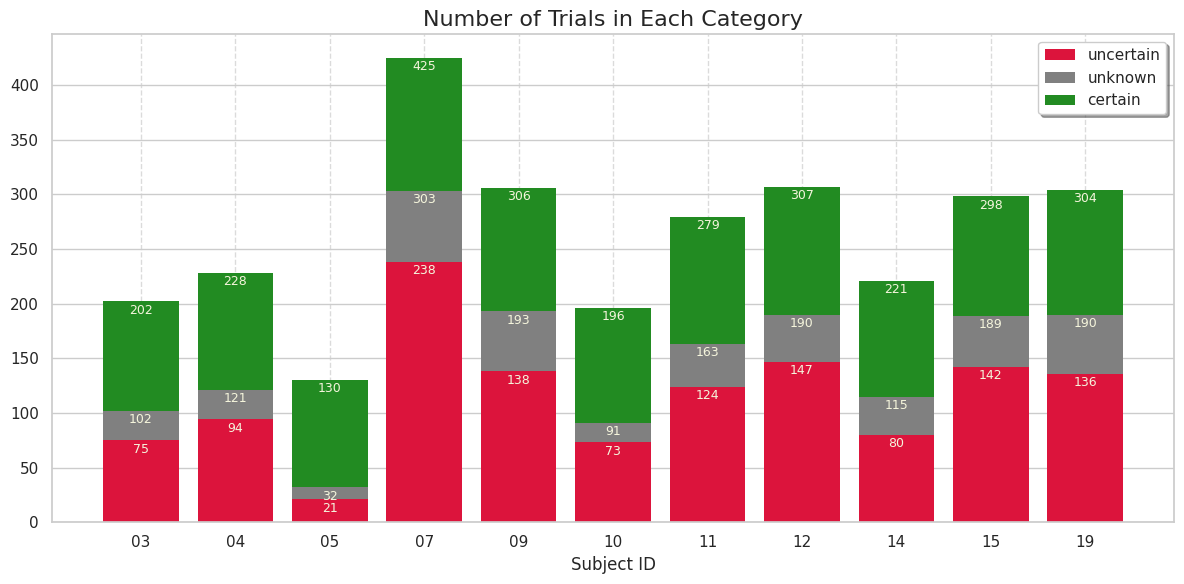

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

trial_categories = data.df_exp['Trial Category'].unique()
colors = ['crimson', 'gray', 'forestgreen']

# dict_n_trials_in_category = {}
# for cat in trial_categories:
#     dict_n_trials_in_category[cat] = data.df_exp[data.df_exp['Trial Category'] == cat].shape[0]

uncertain   = [dict_subject_labels[sub_id]['uncertain'] for sub_id in subject_ids]
unknown     = [dict_subject_labels[sub_id]['unknown'] for sub_id in subject_ids]
certain     = [dict_subject_labels[sub_id]['certain'] for sub_id in subject_ids]
    
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(subject_ids, uncertain, label='uncertain', color=colors[0], edgecolor='none')
ax.bar(subject_ids, unknown, label='unknown', color=colors[1], edgecolor='none', bottom=uncertain)
ax.bar(subject_ids, certain, label='certain', color=colors[2], edgecolor='none', bottom=[uncertain[i] + unknown[i] for i in range(len(uncertain))])
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.legend(loc='upper right', shadow=True)
# sns.set_theme(style="whitegrid")
# ax = sns.countplot(df, x="Subject ID", hue='Trial Category', palette=colors)
# ax.set_xticks([int(x) for x in subject_ids], subject_ids)
for container in ax.containers:
    ax.bar_label(container, fontsize=9, label_type='edge', color='beige', padding=-11)
ax.set_title('Number of Trials in Each Category', fontsize=16)
ax.set_xlabel('Subject ID', fontsize=12)
# ax.set_ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

### Condition labels

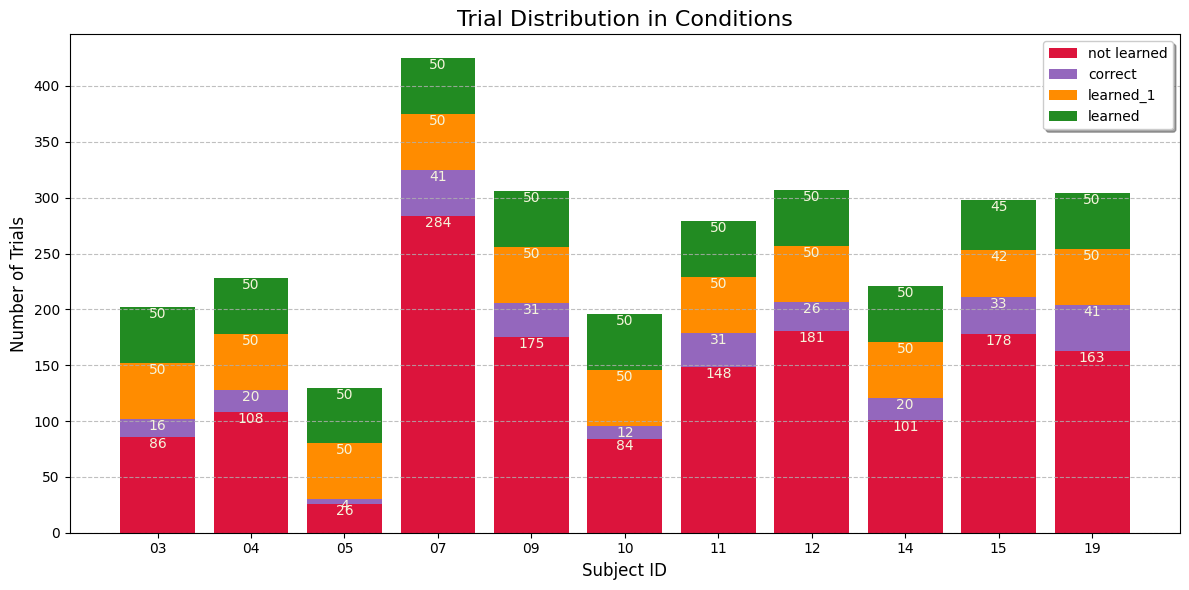

In [3]:
import neuropsy as npsy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path            = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subject_ids     = npsy.utils.get_subject_ids_from_path(path)

#******** Get labels for each subject ********
dict_subject_labels = {}
for i, sub_id in enumerate(subject_ids):
    dict_subject_labels[sub_id] = {}
    
    # load subject data
    data = npsy.DataHandler(path=path, subject_id=sub_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed', load_chan=False, load_ieeg=False, load_targets=False)
    
    # get labels
    for label in data.df_exp['Condition'].unique():
        
        # first subject
        if i == 0:
            df = data.df_exp
        else:
            df = pd.concat([df, data.df_exp])
            
        dict_subject_labels[sub_id][label] = len(data.df_exp.loc[data.df_exp['Condition'] == label])
        

#******** Plotting ********
conditions      = ['not learned', 'correct', 'learned-1', 'learned']
colors          = ['crimson', 'tab:purple', 'darkorange', 'forestgreen']

# dict_n_trials_in_category = {}
# for cat in trial_categories:
#     dict_n_trials_in_category[cat] = data.df_exp[data.df_exp['Trial Category'] == cat].shape[0]

not_learned     = [dict_subject_labels[sub_id]['not learned'] for sub_id in subject_ids]
correct         = [dict_subject_labels[sub_id]['correct'] for sub_id in subject_ids]
learned_1       = [dict_subject_labels[sub_id]['learned-1'] for sub_id in subject_ids]
learned         = [dict_subject_labels[sub_id]['learned'] for sub_id in subject_ids]
    
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(subject_ids, not_learned, label='not learned', color=colors[0], edgecolor='none')
ax.bar(subject_ids, correct, label='correct', color=colors[1], edgecolor='none', bottom=not_learned)
ax.bar(subject_ids, learned_1, label='learned_1', color=colors[2], edgecolor='none', bottom=[not_learned[i] + correct[i] for i in range(len(not_learned))])
ax.bar(subject_ids, learned, label='learned', color=colors[3], edgecolor='none', bottom=[not_learned[i] + correct[i] + learned_1[i] for i in range(len(not_learned))])
ax.grid(axis='y', linestyle='--', alpha=0.8)
ax.legend(loc='upper right', shadow=True)

# sns.set_theme(style="whitegrid")
# ax = sns.countplot(df, x="Subject ID", hue='Trial Category', palette=colors)
# ax.set_xticks([int(x) for x in subject_ids], subject_ids)

# for container in ax.containers:
#     ax.bar_label(container, fontsize=9, label_type='edge', color='beige', padding=-11)

for sub_id in subject_ids:
    ax.text(x=sub_id, y=dict_subject_labels[sub_id]['not learned'], s=dict_subject_labels[sub_id]['not learned'], ha='center', va='top', fontsize=10, color='beige')
    ax.text(x=sub_id, y=dict_subject_labels[sub_id]['not learned']+dict_subject_labels[sub_id]['correct'], s=dict_subject_labels[sub_id]['correct'], ha='center', va='top', fontsize=10, color='beige')
    ax.text(x=sub_id, y=dict_subject_labels[sub_id]['not learned']+dict_subject_labels[sub_id]['correct']+dict_subject_labels[sub_id]['learned-1'], s=dict_subject_labels[sub_id]['learned-1'], ha='center', va='top', fontsize=10, color='beige')
    ax.text(x=sub_id, y=dict_subject_labels[sub_id]['not learned']+dict_subject_labels[sub_id]['correct']+dict_subject_labels[sub_id]['learned-1']+dict_subject_labels[sub_id]['learned'], s=dict_subject_labels[sub_id]['learned'], ha='center', va='top', fontsize=10, color='beige')

ax.set_title('Trial Distribution in Conditions', fontsize=16)
ax.set_xlabel('Subject ID', fontsize=12)
ax.set_ylabel('Number of Trials', fontsize=12)
plt.tight_layout()
# plt.savefig('/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/results/preprocessing/categorise trials/automatic/trial_distribution_conditions.png', dpi=300)
plt.show()

## Plot Electrode Coverage in the Brain Across Subjects

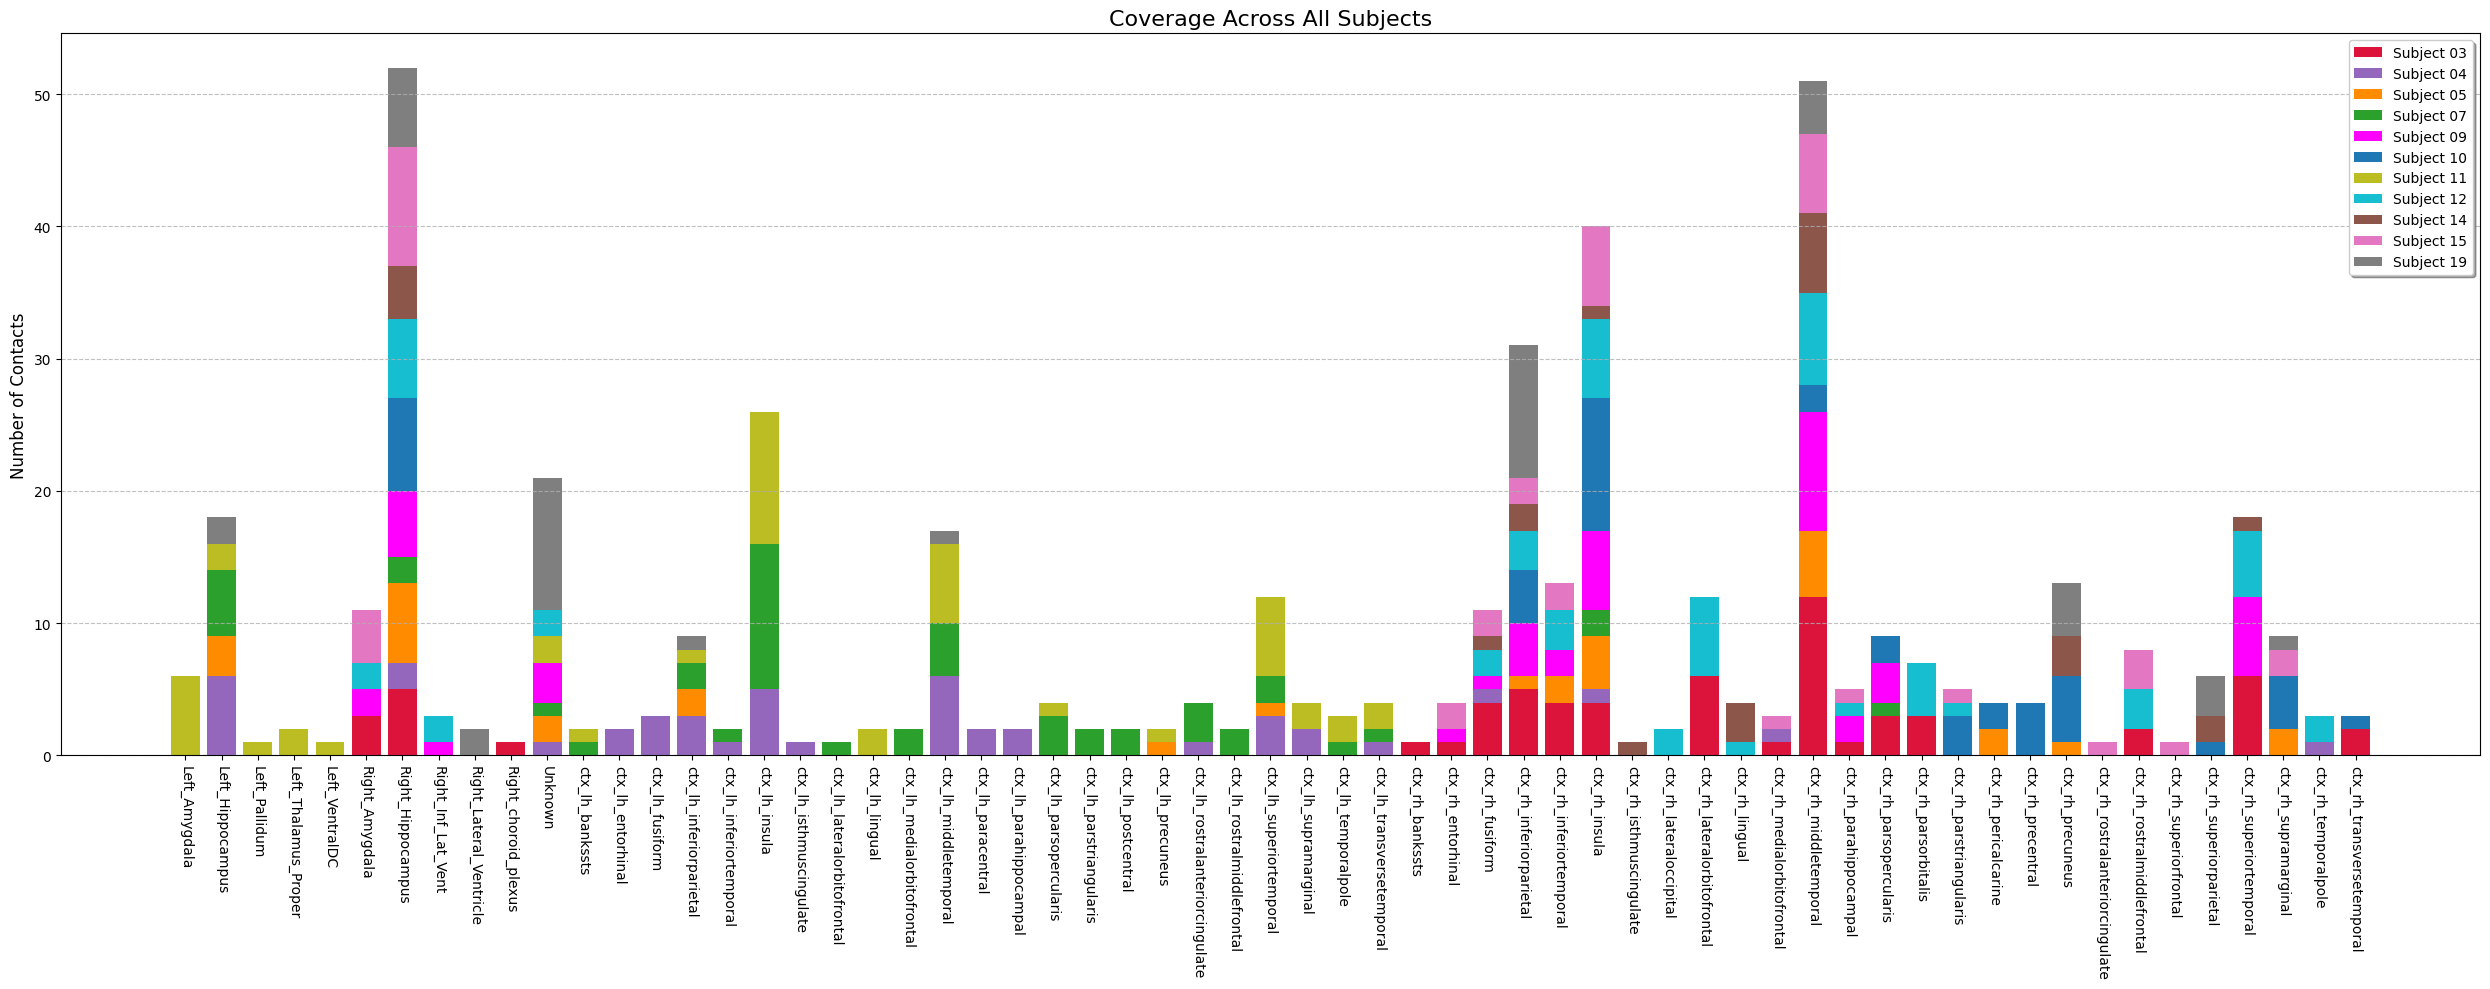

In [71]:
import neuropsy as npsy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path            = '/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/data/preprocessed'
subject_ids     = npsy.utils.get_subject_ids_from_path(path)

#******** Get count of channels in brain regions for each subject ********
dict_region_labels = {}
for i, sub_id in enumerate(subject_ids):
    dict_region_labels[sub_id] = {}
    
    # load subject data
    data = npsy.DataHandler(path=path, subject_id=sub_id, exp_phase=2, fs=512, verbose=False)
    data.load(load_saved=True, postfix='preprocessed', load_chan=True, load_ieeg=False, load_targets=False, load_exp=False)
    
    # get count for each brain region (DK atlas)
    for region in data.df_chan['DK_ROI'].unique():
        
        dict_region_labels[sub_id][region] = len(data.df_chan.loc[data.df_chan['DK_ROI'] == region])
        
# get all unique regions across all subjects (for plotting)
unique_regions = []
for sub_id in subject_ids:
    unique_regions.append(list(dict_region_labels[sub_id].keys()))
unique_regions = list(set([item for sublist in unique_regions for item in sublist]))

# iterate through all unique regions and set region count to zero if not present in subject
for region in unique_regions:
    for sub_id in subject_ids:
        if region not in dict_region_labels[sub_id].keys():
            dict_region_labels[sub_id][region] = 0

# get count of channels in each region for each subject
df = pd.DataFrame(dict_region_labels).T
df = df[sorted(df.columns)]

# ignore irrelevant large columns for nicer plotting
df = df.drop(columns=['Right_Cerebral_White_Matter', 'Left_Cerebral_White_Matter'])

#******** Plotting ********
subject_colors  = ['crimson', 'tab:purple', 'darkorange', 'tab:green', 'magenta', 'tab:blue', 'tab:olive', 'tab:cyan', 'tab:brown', 'tab:pink', 'tab:gray']

fig, ax = plt.subplots(figsize=(25, 10))

bottom = np.zeros(df.shape[1])
for i, sub_id in enumerate(subject_ids):
    ax.bar(df.columns, df.loc[sub_id], color=subject_colors[i], edgecolor='none', label=f'Subject {sub_id}', bottom=bottom)
    bottom += df.loc[sub_id].values

ax.set_title('Coverage Across All Subjects', fontsize=16)
ax.set_ylabel('Number of Contacts', fontsize=12)
ax.tick_params(axis='x', rotation=270)
ax.grid(axis='y', linestyle='--', alpha=0.8)
ax.legend(loc='upper right', shadow=True)
plt.tight_layout()
# plt.savefig('/mnt/c/Users/matti/OneDrive/Education/SDC/MasterThesis/master-project/results/Research Question 2/contact_coverage_roi.png', dpi=300)
plt.show()

# Plot trial error and reaction time

In [8]:
import neuropsy as npsy
import matplotlib.pyplot as plt
import numpy as np

path = '/mnt/c/Users/matti/OneDrive/Education/SDC/Master Thesis/master-project/data/preprocessed'
subject_id = '03'

data = npsy.DataHandler(path=path, subject_id=subject_id, exp_phase=2, fs=512, verbose=False)
data.load(load_saved=True, postfix='preprocessed', load_exp=True, load_chan=False, load_ieeg=False, load_targets=True)
data.df_exp.head()

,x_coordinate,y_coordinate,Picture Number,Subject ID,Mark for Picture Shown,Mark for Picture Placed,Timestamp (s) for Picture Shown,Timestamp (s) for Picture Placed,Reaction Time (computed),Trial Identifier,Trial Error,outlier,Trial Category,Condition
0,240.0,-252.0,47,3,5119,10133,9.998047,19.791016,9.792969,47-1,497.52,False,uncertain,not learned
1,247.0,-254.0,33,3,11738,14864,22.925781,29.031250,6.105469,33-1,376.75,False,uncertain,not learned
2,-248.0,200.0,36,3,16466,18582,32.160156,36.292969,4.132812,36-1,372.78,False,uncertain,not learned
3,-76.0,64.0,44,3,20187,26168,39.427734,51.109375,11.681641,44-1,211.44,True,uncertain,not learned
4,-252.0,-194.0,46,3,27774,29805,54.246094,58.212891,3.966797,46-1,163.09,False,uncertain,not learned


In [11]:
# import numpy as np
%matplotlib Qt5
%gui qt

items = [3, 4, 6, 18, 21, 26] # 18 has outlier
# items = [3]


plot_colors = {
    'outlier': 'salmon',
    'error': 'dodgerblue',
    'reaction_time': 'darkorange',
    'threshold': 'black',
    'current_trial': 'deeppink'
}

# get euclidean distances (trial error)
dict_eucl_distances = {}
for pic in data.df_targets['picture number'].unique():
    dict_eucl_distances[pic] = data.df_exp[data.df_exp['Picture Number']
                                            == pic]['Trial Error'].to_list()

for item in items:
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))
    ax2 = ax.twinx()
    
    # plot all trials for item, but iterate because one trial should be categorised at a time
    n_trials = np.arange(0, len(data.df_exp[data.df_exp['Picture Number'] == item]), step=1)
    x_tick_labels = np.arange(1, len(data.df_exp[data.df_exp['Picture Number'] == item]) + 1, step=1)
    
    # get outlier indices if any
    outlier_arr = data.df_exp[data.df_exp['Picture Number'] == item]['outlier'].to_numpy()
    outlier_indices = np.where(outlier_arr == True)[0]
    
    # ********** Has outliers **********#
    if len(outlier_indices) > 0:
        outlier_indices = outlier_indices.astype(int)
        
        # ********** Plot trial error **********#
        # plot error outlier dot and lines in red
        ax.plot(n_trials, dict_eucl_distances[item], color=plot_colors['outlier'], linestyle='--', linewidth=1)
        ax.plot(n_trials[outlier_indices], np.array(dict_eucl_distances[item])[outlier_indices], marker='o', markersize=5, linestyle='None', color=plot_colors['outlier'], label='outlier')
        ax.legend(loc='best', fontsize=8, shadow=True)
        # ********** Plot reaction time (outlier) **********#
        # plot outlier reaction time dot and line in red
        ax2.plot(data.df_exp[data.df_exp['Picture Number'] == item]['Reaction Time (computed)'].to_numpy(), color=plot_colors['outlier'], linestyle=':', linewidth=0.75)
        ax2.plot(n_trials[outlier_indices], data.df_exp[data.df_exp['Picture Number'] == item]['Reaction Time (computed)'].to_numpy()[outlier_indices], marker='o', markersize=5, linestyle='None', color=plot_colors['outlier'])

        # ********** Plot trial error (no outlier) **********#
        # plot non-outlier error in blue
        x = np.delete(n_trials, outlier_indices)
        y1 = np.delete(dict_eucl_distances[item], outlier_indices)
        # plot a dot if only one point else lines with no dots
        if len(y1) == 1:
            ax.plot(x, y1, marker='o', markersize=5, linestyle='None', color=plot_colors['error'])
        else:
            ax.plot(x, y1, color=plot_colors['error'], linestyle='-', linewidth=1.5)

        # ********** Plot reaction time **********#
        # plot outlier reaction time dot and line in red
        ax2.plot(data.df_exp[data.df_exp['Picture Number'] == item]['Reaction Time (computed)'].to_numpy(), color=plot_colors['outlier'], linestyle=':', linewidth=0.75)
        ax2.plot(n_trials[outlier_indices], data.df_exp[data.df_exp['Picture Number'] == item]['Reaction Time (computed)'].to_numpy()[outlier_indices], marker='o', markersize=5, linestyle='None', color=plot_colors['outlier'])
        # plot non-outlier reaction times line in orange
        y2 = np.delete(data.df_exp[data.df_exp['Picture Number'] == item]['Reaction Time (computed)'].to_numpy(), outlier_indices)
        # plot a dot if only one point else lines with no dots
        if len(y2) == 1:
            ax2.plot(x, y2, marker='o', markersize=5, linestyle='None', color=plot_colors['reaction_time'])
        else:
            ax2.plot(x, y2, color=plot_colors['reaction_time'], linestyle='--', linewidth=1)
    
    # ********** No outliers **********#
    else:
        ax.plot(dict_eucl_distances[item], color=plot_colors['error'], linestyle='-', linewidth=1.5)
        ax2.plot(data.df_exp[data.df_exp['Picture Number'] == item]['Reaction Time (computed)'].to_numpy(), color=plot_colors['reaction_time'], linestyle='--', linewidth=1)
        
        
    ax.set_title(f'Item {item}', fontsize=14)
    ax.set_xlabel('Trial', fontsize=10)
    ax.set_ylabel('Error', color=plot_colors['error'], fontsize=10)
    ax2.set_ylabel('Reaction Time (s)', color=plot_colors['reaction_time'], fontsize=10)
    ax.set_xticks(n_trials, x_tick_labels)
    ax.tick_params(axis='y', labelcolor=plot_colors['error'])
    ax2.tick_params(axis='y', labelcolor=plot_colors['reaction_time'])
    ax.axhline(y=150, color=plot_colors['threshold'], linestyle='--', linewidth=0.75)
    ax.grid(False)
    ax2.grid(False)
    plt.tight_layout()
    plt.show()

qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.
qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1

qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.
